## Capítulo 13 - Explicando Modelos

Modelos preditivos têm diferentes propriedades. Alguns foram concebidos para lidar com dados lineares; outros são capazes de modelar dados de entrada mais complexos. Alguns modelos podem ser muito facilmente interpretados, enquanto outros são como 'caixas-pretas' e não oferecem muito insights acerca como a predição é feita.

Neste capítulo, veremos como interpretar diferentes modelos. Analisaremos alguns exemplos usando os dados do Titanic.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
from yellowbrick.model_selection import (
    ValidationCurve,
)

In [2]:
# Caminho em Pasta
path = "datasets/titanic/titanic3.xls"
df = pd.read_excel(path)
orig_df = df

In [3]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [4]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

### Coeficientes de regressão

Os interceptos e os coeficientes de regressão explicam o valor esperado e como os atributos causam impacto na predição. Um coeficiente positivo indica que, à medida que o valor de um atributo aumenta, o mesmo ocorrerá com a predição.

### Importância dos atributos

Modelos baseados em árvore da biblioteca scikit-learn incluem um atributo '.feature_importances_' para inspecionar como os atributos de um conjunto de dados afetam o modelo. Podemos inspecionar esses dados ou colocá-los em um gráfico.

#### LIME

O LIME (https://oreil.ly/shCR_) ajuda a explicar modelos caixa-preta. Ele faz uma interpretação local, em vez de uma interpretação geral, e ajuda a explicar uma única amostra.

Para um determinado ponto de dado ou amostra, o LIME mostra quais atributos foram importantes para determinar o resultado. Ele faz isso causando uma perturbação na amostra em questão e fazendo a adequação de um modelo linear para ela. O modelo linear aproxima oo modelo à amostra.

###### Eis um modelo que explica à última amostra (para a qual nossa árvore de decisão fez a previsão que sobreviveria) dos dados de treinamento:

In [6]:
#!pip install lime

In [7]:
from lime import lime_tabular

In [8]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X.columns,
    class_names=["died", "survived"],
)
exp = explainer.explain_instance(
    X_train.iloc[-1].values, dt.predict_proba
)

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


###### O LIME não gosta de usar DataFrames como entrada. Observe que convertemos os dados em arrays numpy usando '.values'

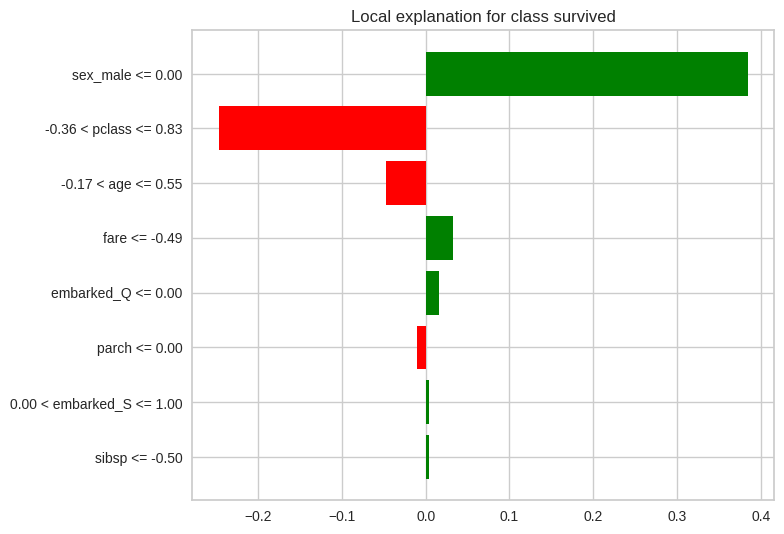

In [9]:
fig = exp.as_pyplot_figure()
fig.tight_layout()
fig.savefig("images/mlpr_1301.png")

Observe que trocar o sexo, o resultado será afetado. A seguir, consideramos a antepenúltima linha dos dados de treinamento. A predição para essa linha é de 48% para falecimentos e 52% para sobrevivência. Se trocarmos o sexo, veremos que a predição muda para 88% dde falecimento:

In [10]:
data = X_train.iloc[-2].values.copy()
dt.predict_proba(
    [data]
) # previsão de que uma mulher sobreviva

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([[0.48062016, 0.51937984]])

In [11]:
data[5] = 1 # Muda para o sexo masculino
dt.predict_proba([data])

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([[0.87954545, 0.12045455]])

###### NOTA: O método '.predict_proba' devolve uma probabilidade para cada rótulo.

#### Interpretação de árvores

Para modelos baseados em árvore do sklearn (árvore de decisão, floresta aleatória e outros modelos de árvore), podemos usar o pacote 'treeinterpreter' (https://oreil.ly/vN1Bl). Ele calculará o bias (viés) e a contribuição de cada atributo. O bias é a média do conjunto de treinamentos.

Cada contribuição lista como o atributo contribui com cada um dos rótulos. (A soma do bias mais as contribuições deve ser igual à predição). Como essa é uma classificação binária, há apenas dois rótulos. Vemos que 'sex_male' é o atributo mais importante, seguido de age (idade) e fare (preço da passagem).

In [12]:
#!pip install treeinterpreter

In [13]:
from treeinterpreter import (
    treeinterpreter as ti,
)

In [14]:
rf5 = ensemble.RandomForestClassifier(
    **{
        "max_features": "auto",
        "min_samples_leaf": 0.1,
        "n_estimators": 200,
        "random_state": 42,
    }
)
rf5.fit(X_train, y_train)

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', min_samples_leaf=0.1,
                       n_estimators=200, random_state=42)

In [15]:
instances = X.iloc[:2]
prediction, bias, contribs = ti.predict(
    rf5, instances
)

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWar

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWar

In [16]:
i = 0 
print("Instance", i)
print("Prediction", prediction[i])
print("Bias (trainset mean)", bias[i])
print("Feature contributions: ")
for c, feature in zip(
    contribs[i], instances.columns
):
    print("   {} {}".format(feature, c))

Instance 0
Prediction [0.82046191 0.17953809]
Bias (trainset mean) [0.63887555 0.36112445]
Feature contributions: 
   pclass [ 0.02865085 -0.02865085]
   age [ 0.01115629 -0.01115629]
   sibsp [ 0.00528926 -0.00528926]
   parch [ 0.00656872 -0.00656872]
   fare [ 0.04126856 -0.04126856]
   sex_male [ 0.07660626 -0.07660626]
   embarked_Q [0. 0.]
   embarked_S [ 0.01204643 -0.01204643]


#### Modelos substitutos

Se tiver um modelo que não seja interpretável (SVM ou rede neural), poderá fazer adequação de um modelo interpretável (árvore de decisão) para esse modelo. Ao usar o modelo substituto (surrogate model), poderá analisar a importância dos atributos.

Em nosso exemplo, criaremos um SVC, mas faremos o treinamento de uma árvore de decisão (sem um limite de prodfundidade para superadequação e para capturar o que acontece nesse modelo).

In [17]:
from sklearn import svm
sv = svm.SVC()
sv.fit(X_train, y_train)
sur_dt = tree.DecisionTreeClassifier()
sur_dt.fit(X_test, sv.predict(X_test))
for col, val in sorted(
    zip(
        X_test.columns,
        sur_dt.feature_importances_,
    ),
    key=lambda x:x[1],
    reverse=True,
)[:7]:
    print(f"{col:10}{val:10.3f}")

sex_male       0.596
embarked_S     0.126
pclass         0.115
age            0.073
sibsp          0.037
fare           0.034
parch          0.019


#### Shapley

O pacote SHAP(SHapley Additive exPlanations, https://oreil.ly/QYj-q) é capaz de exibir as contribuições dos atributos para qualquer modelo. É um pacote realmente muito bom, pois não só funciona para a maioria dos modelos como também é capaz de explicar predições individuais e as contribuições globais dos atributos.

O SHAP funciona tanto para classificação como para regressão e gera valores "SHAP". Para modelos de classificação, o valor SHAP é a soma dos log odds (logaritmo das chances) em uma classificação binária. Para regressão, os valores SHAP são a soma da predição do alvo.

Essa biblioteca exige o Jupyter (JavaScript) para interatividade em alguns de seus gráficos. (Alguns podem renderizar imagens estáticas com a matplotlib). 

###### Eis um exemplo para a amostra 20, cuja previsão é de falecimento:

In [18]:
rf5.predict_proba(X_test.iloc[[20]])

array([[0.60129761, 0.39870239]])

In [19]:
#!pip install shap

No gráfico de forças (force plot) para a amostra 20, podemos ver o "valor de base". É uma mulher, e a previsão é de que faleceria.

In [20]:
import shap
shap.initjs()
s = shap.TreeExplainer(rf5)
shap_vals = s.shap_values(X_test)
target_idx = 1
shap.force_plot(
    s.expected_value[target_idx],
    shap_vals[target_idx][20, :],
    feature_names=X_test.columns,
)

Usaremos o índice de sobrevivência (1) porque queremos que o lado direito do gráfico seja a sobrevivência. Os atributos forçam isso para a direita ou para a esquerda. Quanto maior o atributo, mais impacto ele causará. Neste caso, um valor baixo de fare (preço da passagem) e a terceira classe pressionam em direção ao falecimento (o valor do resultado está abaixo de 0,5).

###### Também pode visualizar as explicações para o conjunto de dados completo (fazendo uma rotação de 90 graus e a plotagem no eixo x).

In [21]:
shap.force_plot(
    s.expected_value[1],
    shap_vals[1],
    feature_names=X_test.columns,
)

A biblioteca SHAP também pode gerar gráficos de dependência. O gráfico a seguir mostra o relacionamento entre a idade(age) e o valor SHAP (está colorido de acordo com pclass, que o SHAP seleciona automaticamente; especifique um nome de coluna no parâmetro 'interaction_index' para escolher o seu próprio atributo):

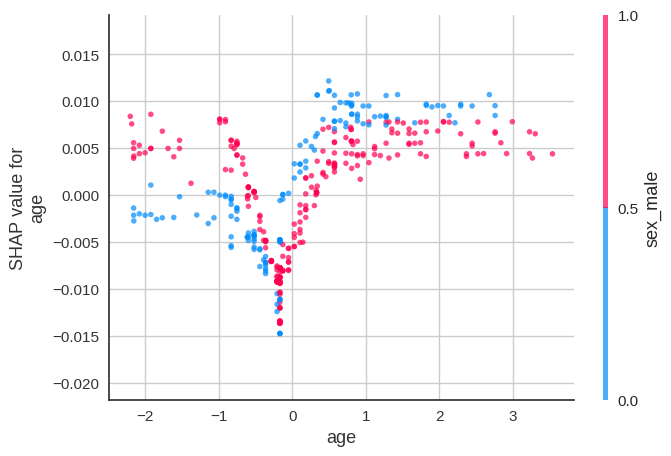

In [22]:
res = shap.dependence_plot(
    "age", 
    shap_vals[target_idx],
    X_test,
    feature_names=X_test.columns,
    alpha=0.7,
)

Além disso, podemos fazer uma síntese de todos os atributos. Esse é um gráfico muito eficaz para a compreensão dos dados. Ele mostra o impacto global, mas também os impactos individuais. Os atributos são classificados segundo a importância, e os mais importantes estão na parte superior.

Além disso, os atributos recebem cores de acordo com seus valores. Podemos ver que uma pontuação baixa para sex_male (female, ou seja, sexo feminino) pressiona mais em direção à sobrevivência, enquanto uma pontuação alta exerce menos pressão. O atributo age (idade) é um pouco mais difícil de ser interpretado. Isso porque valores para mais jovens e mais velhos pressionam em direção à sobrevivência, enquanto idades medianas pressionam em direção ao falecimento.

Ao combinar o gráfico de síntese com o gráfico de dependências, poderá ter bons insights sobre o comportamento do modelo.

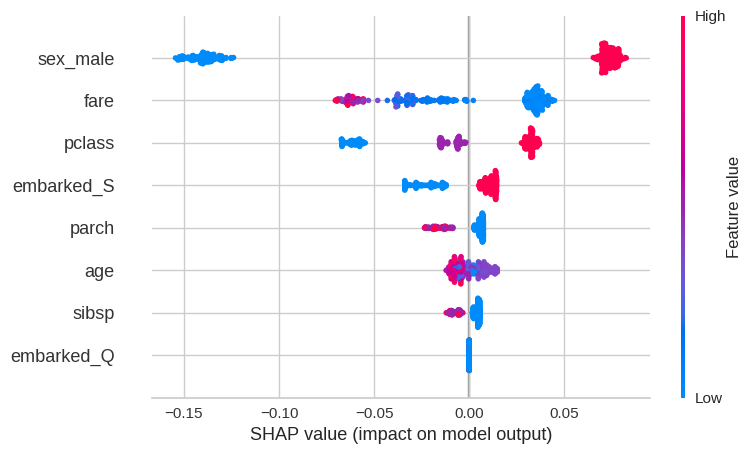

In [23]:
shap.summary_plot(shap_vals[0], X_test)